In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout


In [11]:
data = pd.read_csv("../processed/merged_clean.csv")
print("Original shape:", data.shape)

# Keep only numeric columns
data = data.select_dtypes(include=["float64", "int64"])
# Replace infinities and drop NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("Cleaned shape:", data.shape)

Original shape: (3437, 20)
Cleaned shape: (3437, 19)


In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print("Scaled data shape:", scaled_data.shape)

Scaled data shape: (3437, 19)


In [13]:
SEQ_LEN = 60  # how many time steps per sample
X, y = [], []

# Predict next value of the first column (you can later replace this with insomnia_score)
for i in range(len(scaled_data) - SEQ_LEN):
    X.append(scaled_data[i:i+SEQ_LEN])      # 60 previous time steps
    y.append(scaled_data[i+SEQ_LEN, 0])     # predict the next step's first feature

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print("✅ X shape:", X.shape)
print("✅ y shape:", y.shape)

✅ X shape: (3377, 60, 19)
✅ y shape: (3377,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2701, 60, 19) Test: (676, 60, 19)


In [15]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # sigmoid for 0–1 probability
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

c:\Users\Raphael Jay Escosia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 64)         │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,849 (151.75 KB)

 Trainable params: 38,849 (151.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0489 - mae: 0.1704 - val_loss: 0.0035 - val_mae: 0.0445
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - mae: 0.0605 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mae: 0.0415 - val_loss: 0.0013 - val_mae: 0.0287
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mae: 0.0384 - val_loss: 6.5469e-04 - val_mae: 0.0186
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - mae: 0.0348 - val_loss: 4.7201e-04 - val_mae: 0.0164
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - mae: 0.0282 - val_loss: 5.6747e-04 - val_mae: 0.0171
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 4.8569e-04 - val_mae: 0.0170
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

In [17]:
loss, mae = model.evaluate(X_test, y_test)
print(f"\n📉 Test Loss (MSE): {loss:.4f}")
print(f"📊 Test MAE: {mae:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9286e-04 - mae: 0.0108

📉 Test Loss (MSE): 0.0003
📊 Test MAE: 0.0112


In [18]:
y_pred = model.predict(X_test)
y_pred_percentage = y_pred * 100

print("\nSample predictions (as insomnia probability %):")
print(y_pred_percentage[:10].flatten())

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Sample predictions (as insomnia probability %):
[99.8851      0.29279694 40.598583   79.193184   23.079473   80.820625
  5.8693743  70.916214    6.6451917  54.33172   ]


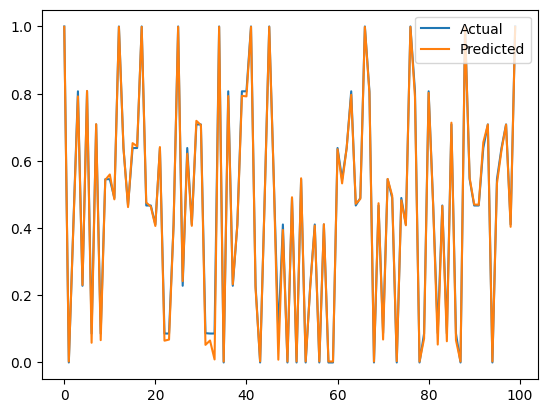

In [19]:
import matplotlib.pyplot as plt
plt.plot(y_test[:100], label="Actual")
plt.plot(y_pred[:100], label="Predicted")
plt.legend()
plt.show()
